## Importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing business class data




In [3]:
business_data = pd.read_csv("/content/drive/MyDrive/business.csv")

## Importing economy class data

In [4]:
economy_data = pd.read_csv("/content/drive/MyDrive/economy.csv")

In [5]:
business_data['class'] = "Business" # adding column "class" to recognize class after merge data

In [6]:
business_data.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612",Business
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612",Business
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220",Business
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450",Business
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690",Business


In [7]:
economy_data['class'] = "Economy" # adding column "class" to recognize class after merge data

In [8]:
economy_data.head() # both files have the same structure so is possible to merge this datasets

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",Economy
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",Economy
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956",Economy
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955",Economy
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955",Economy


In [9]:
df = pd.concat([economy_data, business_data]) # merging datasets "business" and "economy"

In [10]:
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",Economy
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",Economy
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956",Economy
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955",Economy
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955",Economy


## Modifying data to match the structure from the 'Clean dataset' file.

In [11]:
import re

def check_time_format(df):
    # Pattern for the time format
    pattern = re.compile(r'^\d{1,2}h \d{2}m$')

    # Filter values that don't match the pattern
    mismatched_values = df["time_taken"][~df["time_taken"].str.match(pattern)]

    return mismatched_values.tolist()

# Use the function and print non-matching values
non_matching_values = check_time_format(df)
if non_matching_values:
    print("Values not matching the pattern:", non_matching_values)
else:
    print("All values match the pattern.")




Values not matching the pattern: ['1.03h m', '1.02h m', '1.03h m', '1.01h m']


Funtion checked that is 2 type of format data in column "time_take"

In [12]:
def convert_to_decimal(time_str):
    if "h m" in time_str:  # Check if the format is "1.03h m"
        time_parts = time_str.replace('h m', '').split('.')
        hours = int(time_parts[0])
        minutes = int(time_parts[1])
        return round(hours + minutes / 60.0, 2)
    else:  # Default format "03h 45m"
        hours, minutes = map(int, time_str.replace('h', '').replace('m', '').split())
        return round(hours + minutes / 60.0, 2)


In [13]:
df["duration"] = df["time_taken"].apply(convert_to_decimal)

Function changed 2 format of hours to float number

In [14]:
df["date"] = pd.to_datetime(df["date"], format='%d-%m-%Y')

In [15]:
# Data for comparison
target_date = pd.Timestamp('2022-02-10')

# Function to calculate the number of days to the target date
def days_to_target(row_date, target_date):
    delta = row_date - target_date
    return delta.days

# Applying the function to the 'date' column and saving the results in a new 'days' column
df['days'] = df['date'].apply(lambda x: days_to_target(x, target_date))


In [16]:
df["stop"].unique()

array(['non-stop ',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IXU\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Chennai\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Indore\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia RPR\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '2+-stop',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Lucknow\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia GOP\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Raipur\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Nagpur\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Surat\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Hyderabad\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia STV\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t

In [17]:
def create_stop_2_column(df):
    # Function to map the 'stop' column values to a new format
    def map_stops(word):
        # Check if the word is a string
        if isinstance(word, str):
            # Map 'non-stop' to 'zero'
            if 'non-stop' in word:
                return 'zero'
            # Map '1-stop' to 'one'
            elif '1-stop' in word:
                return 'one'
            # Map '2+-stop' to 'two_plus'
            elif '2+-stop' in word:
                return 'two_plus'
        # Return None for values that don't match any of the above conditions
        return None

    # Apply the mapping function to the 'stop' column and store the results in a new column 'stop_2'
    df['stop_2'] = df['stop'].apply(map_stops)


Function transforms datas in column stop and creating column stop_2 with information about number of stop: [zero, one, two_plus]

In [18]:
create_stop_2_column(df)

In [19]:
def categorize_time(time_str):
    # Convert the hour to an integer
    hour = int(time_str.split(":")[0])

    # Segment into times of day
    if 0 <= hour < 4:
        return 'Late_Night'
    elif 4 <= hour < 8:
        return 'Early_Morning'
    elif 8 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'


In [20]:
df['departure_time'] = df['dep_time'].apply(categorize_time) # applying the function
df["arrival_time"] = df['arr_time'].apply(categorize_time) # applying the function

In [21]:
df["price"] = df["price"].str.replace(",", "").astype(float) # changing "price" column format to float

In [22]:
# exchange rate INR-PLN to better understand price for Polish projects readers
inr_pln_exchange = 0.05

In [23]:
# Creating a 'price_pln' column as a result of multiplying the 'price' column by 'inr_pln_exchange'
df["price_pln"] = df["price"] * inr_pln_exchange

In [24]:
# Combining 'ch_code' and 'num_code' with a dash to make a new 'flight' column
df["flight"] = df["ch_code"].astype(str) + "-" + df["num_code"].astype(str)

In [25]:
# rename columns to clean_dataset schema
rename_column = {"from" : "source_city", "to" : "destination_city", "stop_2" : "stops", "days" : "days_left"}

In [26]:
df.rename(columns=rename_column, inplace=True)

In [27]:
df.head()

,date,airline,ch_code,num_code,dep_time,source_city,time_taken,stop,arr_time,destination_city,price,class,duration,days_left,stops,departure_time,arrival_time,price_pln,flight
0,2022-02-11,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,5953.0,Economy,2.17,1,zero,Evening,Night,297.65,SG-8709
1,2022-02-11,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,5953.0,Economy,2.33,1,zero,Early_Morning,Morning,297.65,SG-8157
2,2022-02-11,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,5956.0,Economy,2.17,1,zero,Early_Morning,Early_Morning,297.80,I5-764
3,2022-02-11,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,5955.0,Economy,2.25,1,zero,Morning,Afternoon,297.75,UK-995
4,2022-02-11,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,5955.0,Economy,2.33,1,zero,Morning,Morning,297.75,UK-963


In [28]:
choosen_column = ["airline", "flight", "source_city", "departure_time", "stops", "arrival_time", "destination_city", "class", "duration", "days_left", "price_pln"]

In [29]:
df = df[choosen_column]

In [30]:
df = df[~df['airline'].isin(['StarAir', 'Trujet'])] # airline deleted for data irrelevance (to little this airlines data)

In [31]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price_pln
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,297.65
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,297.65
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,297.80
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,297.75
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,297.75


In [32]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique value for {column} is {unique_values}")
    print("-" * 100)

Unique value for airline is ['SpiceJet' 'AirAsia' 'Vistara' 'GO FIRST' 'Indigo' 'Air India']
----------------------------------------------------------------------------------------------------
Unique value for flight is ['SG-8709' 'SG-8157' 'I5-764' ... '6E-7127' '6E-7259' 'AI-433']
----------------------------------------------------------------------------------------------------
Unique value for source_city is ['Delhi' 'Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai']
----------------------------------------------------------------------------------------------------
Unique value for departure_time is ['Evening' 'Early_Morning' 'Morning' 'Afternoon' 'Night' 'Late_Night']
----------------------------------------------------------------------------------------------------
Unique value for stops is ['zero' 'one' 'two_plus']
----------------------------------------------------------------------------------------------------
Unique value for arrival_time is ['Night' 'Morning' 'Early

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300159 entries, 0 to 93486
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300159 non-null  object 
 1   flight            300159 non-null  object 
 2   source_city       300159 non-null  object 
 3   departure_time    300159 non-null  object 
 4   stops             300159 non-null  object 
 5   arrival_time      300159 non-null  object 
 6   destination_city  300159 non-null  object 
 7   class             300159 non-null  object 
 8   duration          300159 non-null  float64
 9   days_left         300159 non-null  int64  
 10  price_pln         300159 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 27.5+ MB


Very good quality data - no missing value

In [34]:
df.isna().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price_pln           0
dtype: int64

No null values

In [35]:
print(df['airline'].value_counts())

Vistara      127859
Air India     80894
Indigo        43120
GO FIRST      23177
AirAsia       16098
SpiceJet       9011
Name: airline, dtype: int64


In [36]:
print(df['airline'].value_counts(normalize=True)*100)

Vistara      42.597090
Air India    26.950383
Indigo       14.365720
GO FIRST      7.721574
AirAsia       5.363158
SpiceJet      3.002076
Name: airline, dtype: float64


<Axes: xlabel='airline', ylabel='count'>

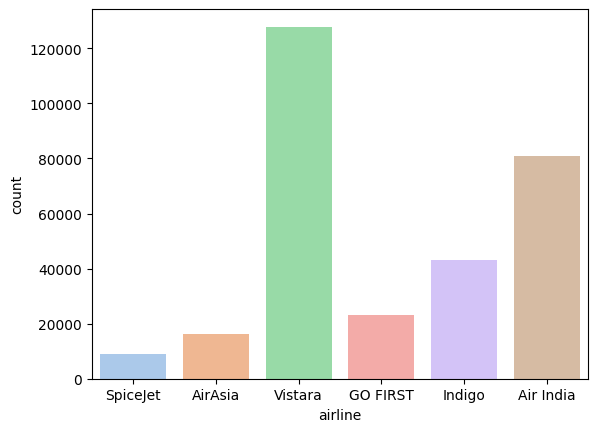

In [37]:
sns.countplot(data=df, x="airline", palette="pastel")

Overwhelming part of records contains 3 airlines: Visatra, Air India, Indigo.

<Axes: xlabel='airline', ylabel='count'>

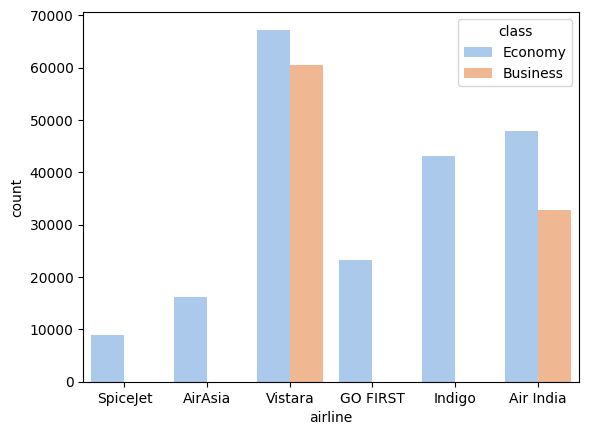

In [38]:
sns.countplot(data=df, x="airline", palette="pastel", hue="class")

Countplot divided into classes: economy and business. Only 2 lines have offers in the business class: Vistara i AirIndia.

<Axes: xlabel='duration', ylabel='price_pln'>

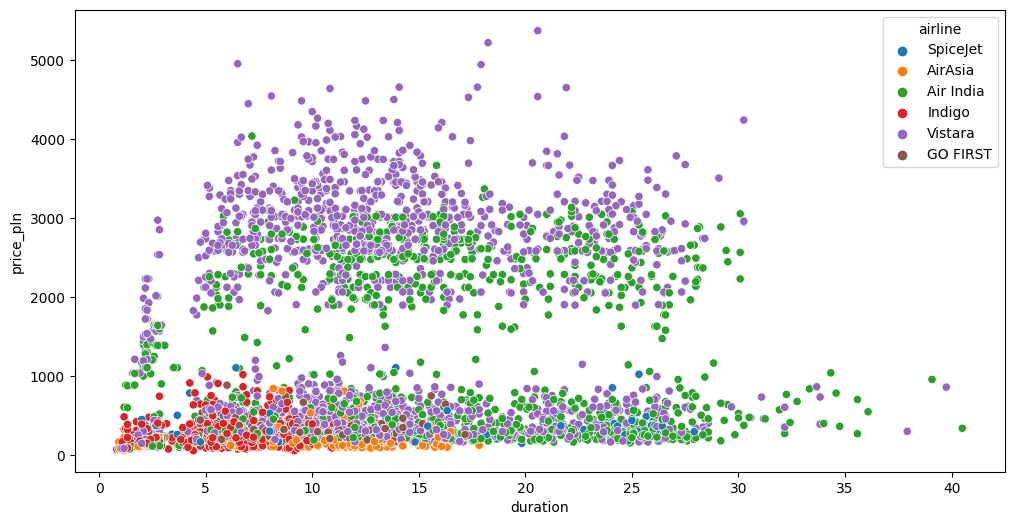

In [39]:
df_sample = df.sample(n=5000) # sample to better visualization
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_sample, x="duration", y="price_pln", hue='airline')

Plot shows that Air India and Vistara has more long and expensive flight

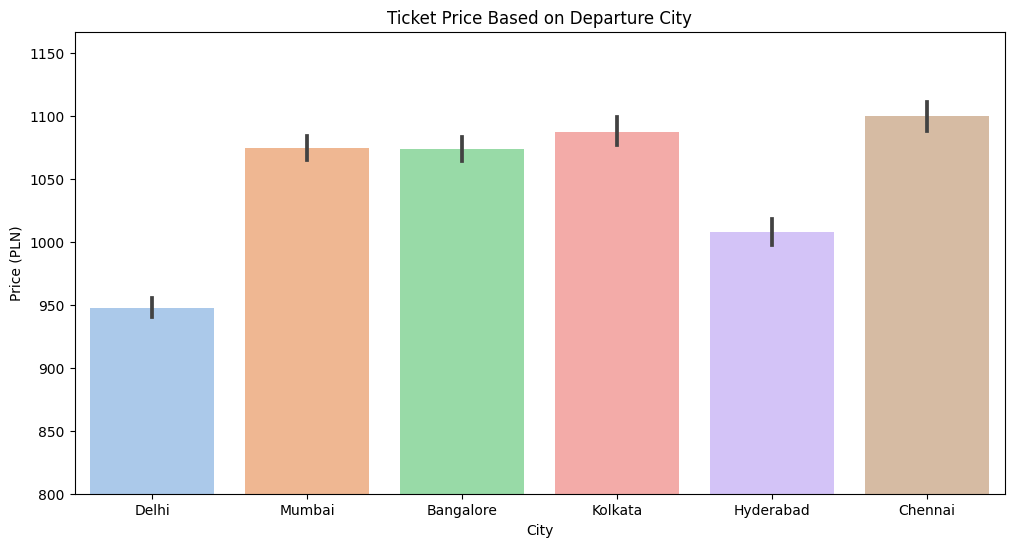

In [40]:
plt.figure(figsize=(12, 6))
sns.barplot(x='source_city', y='price_pln', data=df, palette="pastel")

# Setting the title of the plot
plt.title('Ticket Price Based on Departure City')

# Setting the label for the x-axis
plt.xlabel('City')

# Setting the label for the y-axis
plt.ylabel('Price (PLN)')

# Setting the y-axis limits
plt.ylim(800, None)

# Displaying the plot
plt.show()



The chart shows similar prices for most departure cities. Only flights from Delhi and Hyderabad have noticeably lower fares.

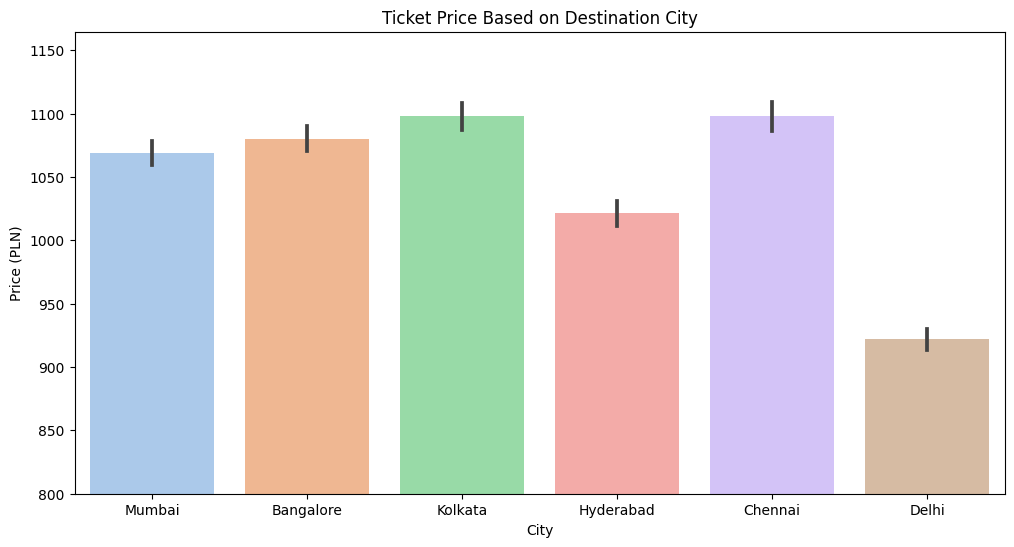

In [41]:
plt.figure(figsize=(12, 6))
sns.barplot(x='destination_city', y='price_pln', data=df, palette="pastel")

# Setting the title of the plot
plt.title('Ticket Price Based on Destination City')

# Setting the label for the x-axis
plt.xlabel('City')

# Setting the label for the y-axis
plt.ylabel('Price (PLN)')

# Setting the y-axis limits
plt.ylim(800, None)

# Displaying the plot
plt.show()



Observations are similar to the previous chart.

In [42]:
def prepare_route_data(df):
    # Creating a route column
    routes = df[["source_city", "destination_city", "price_pln"]].copy()
    routes["route"] = routes["source_city"] + "-" + routes["destination_city"]

    # Calculating the average price for each route
    average_route_price = routes.groupby('route')['price_pln'].mean().reset_index()

    # Sorting routes so that they are paired
    average_route_price['sort_key'] = average_route_price['route'].apply(lambda x: tuple(sorted(x.split('-'))))
    average_route_price = average_route_price.sort_values(by=['sort_key', 'route'], ascending=[True, False])

    # Removing the sort_key column and rounding the price values to 2 decimal places
    average_route_price = average_route_price.drop(columns='sort_key').reset_index(drop=True)
    average_route_price['price_pln'] = average_route_price['price_pln'].round(2)

    return average_route_price

# Using the function
paired_routes = prepare_route_data(df)
paired_routes



,route,price_pln
0,Chennai-Bangalore,1254.09
1,Bangalore-Chennai,1166.09
2,Delhi-Bangalore,894.01
3,Bangalore-Delhi,886.17
4,Hyderabad-Bangalore,1067.36
5,Bangalore-Hyderabad,1061.21
6,Kolkata-Bangalore,1137.24
7,Bangalore-Kolkata,1174.91
8,Mumbai-Bangalore,1157.39
9,Bangalore-Mumbai,1156.36


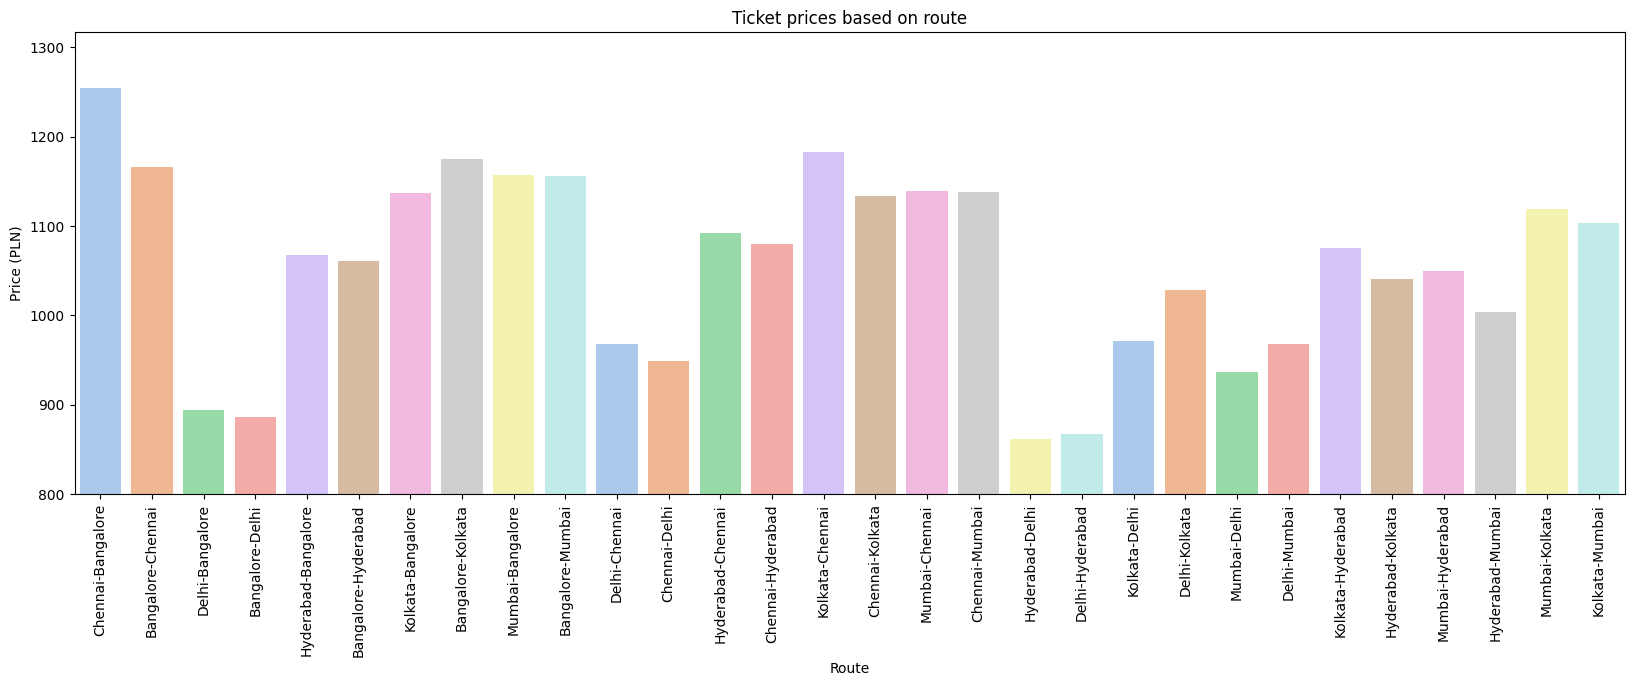

In [43]:
plt.figure(figsize=(20, 6))
sns.barplot(x='route', y='price_pln', data=paired_routes, palette="pastel")

# Setting the title of the plot
plt.title('Ticket prices based on route')
# Setting the label for the x-axis
plt.xlabel('Route')
# Setting the label for the y-axis
plt.ylabel('Price (PLN)')
# Rotating the x-axis labels for better readability
plt.xticks(rotation=90)
# Setting the y-axis limit to start from 800
plt.ylim(800, None)
# Displaying the plot
plt.show()


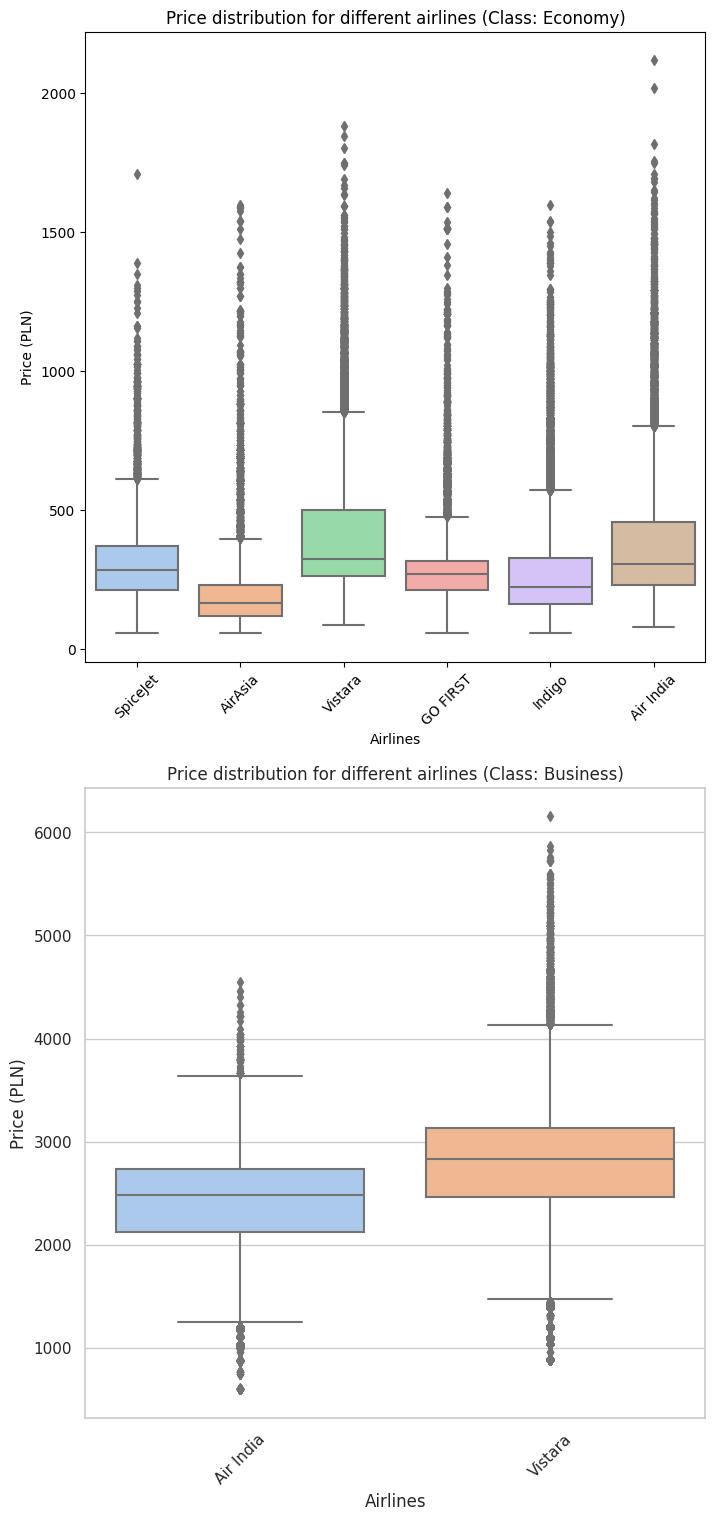

In [44]:

# Filter df to only include rows with class "Economy"
filtered_economy_df = df[df["class"] == "Economy"]
filtered_business_df = df[df["class"] == "Business"]

plt.figure(figsize = (8,18))

# Plot for "Economy" class
plt.subplot(2,1,1)
sns.set(style="whitegrid")
sns.boxplot(x='airline', y='price_pln', data=filtered_economy_df, palette="pastel")
plt.title('Price distribution for different airlines (Class: Economy)')
plt.xticks(rotation=45)
plt.xlabel('Airlines')
plt.ylabel('Price (PLN)')

# Plot for "Business" class
plt.subplot(2,1,2)
sns.set(style="whitegrid")
sns.boxplot(x='airline', y='price_pln', data=filtered_business_df, palette="pastel")
plt.title('Price distribution for different airlines (Class: Business)')
plt.xticks(rotation=45)
plt.xlabel('Airlines')
plt.ylabel('Price (PLN)')

plt.show()




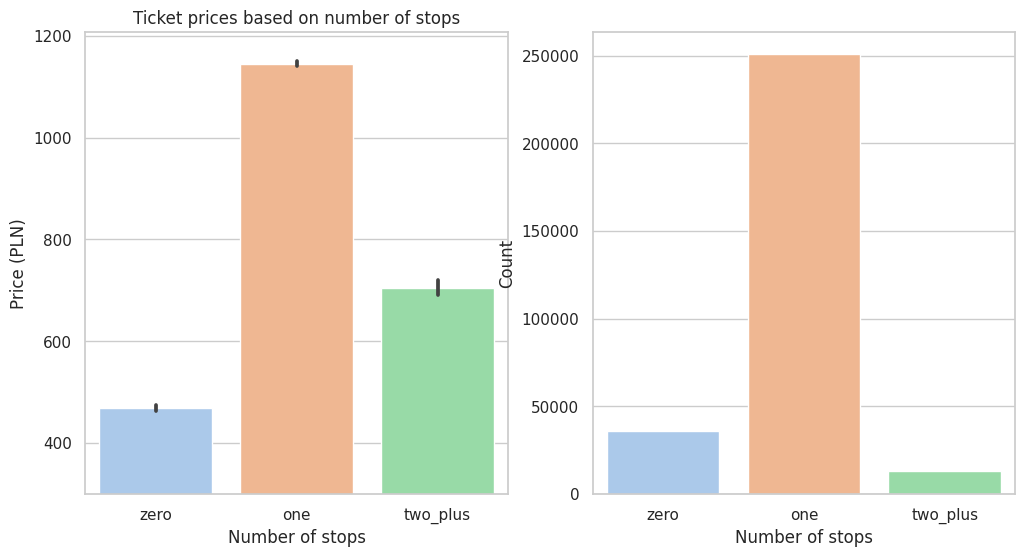

In [45]:
plt.figure(figsize=(12, 6))

# Plot for ticket prices based on number of stops
plt.subplot(1,2,1)
sns.barplot(x='stops', y='price_pln', data=df, palette="pastel")
plt.title('Ticket prices based on number of stops')
plt.xlabel('Number of stops')
plt.ylabel('Price (PLN)')
plt.ylim(300, None)

# Plot for count of each stop category
plt.subplot(1,2,2)
sns.countplot(data=df, x="stops", palette="pastel")
plt.xlabel('Number of stops')
plt.ylabel('Count')

plt.show()


<ipython-input-46-b9df4c49a6d8>:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='days_left', y='price_pln', data=avg_prices_days_left, palette="pastel", marker="o")


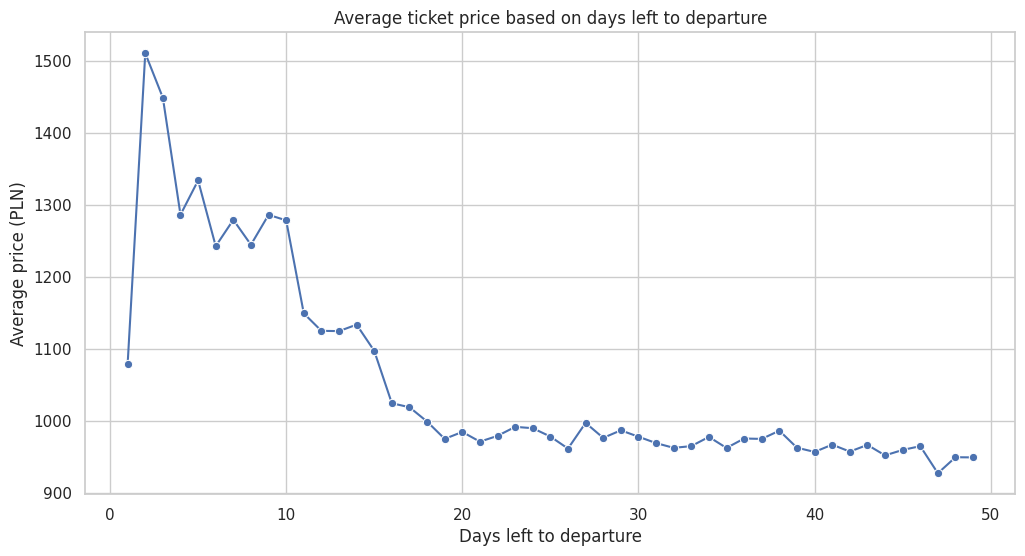

In [46]:
# Calculate the average price for each 'days_left' value
avg_prices_days_left = df.groupby('days_left')['price_pln'].mean().reset_index()

# Plot a line chart
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='days_left', y='price_pln', data=avg_prices_days_left, palette="pastel", marker="o")
plt.title('Average ticket price based on days left to departure')
plt.xlabel('Days left to departure')
plt.ylabel('Average price (PLN)')
plt.grid(True)
plt.show()



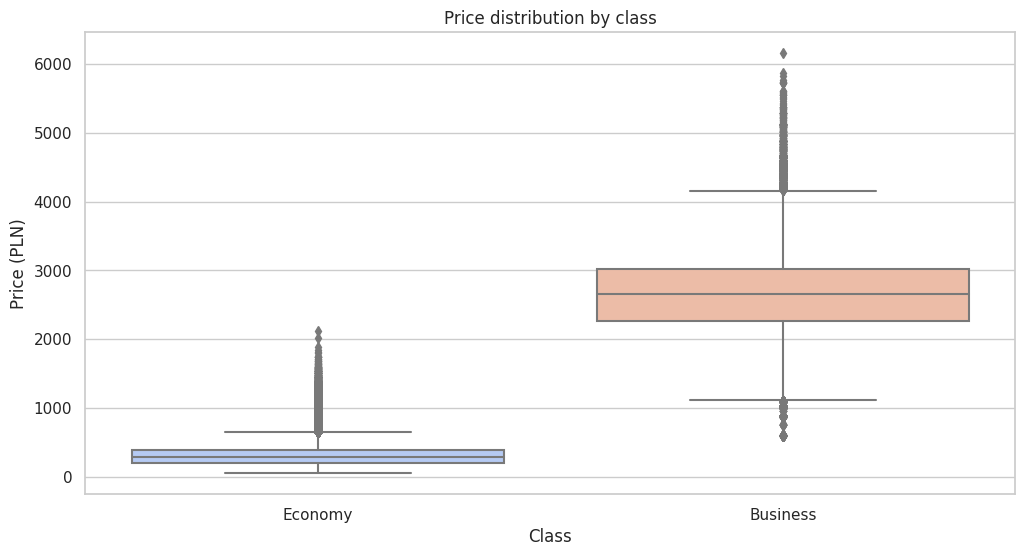

In [47]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='price_pln', data=df, palette="coolwarm")
plt.title('Price distribution by class')
plt.xlabel('Class')
plt.ylabel('Price (PLN)')
plt.show()


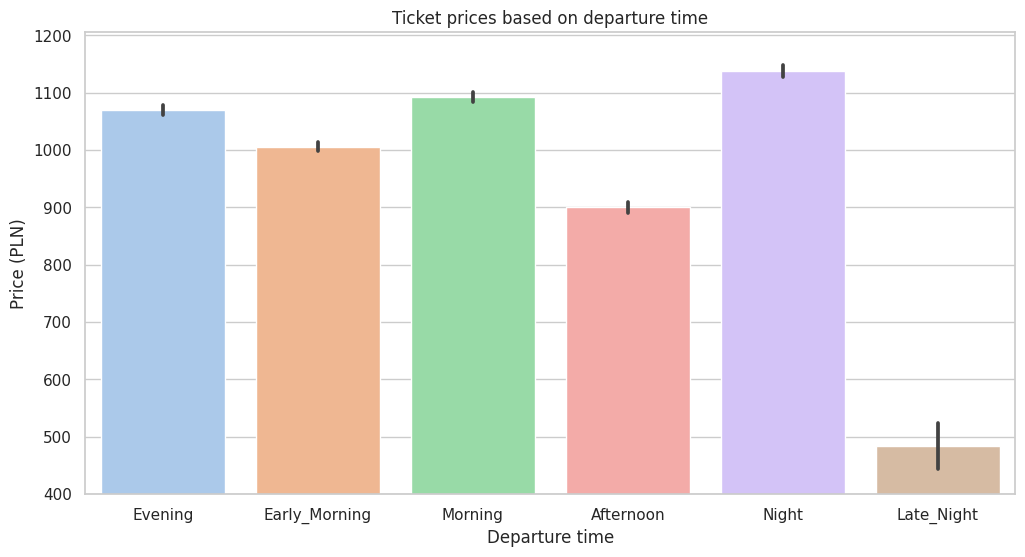

In [48]:
plt.figure(figsize=(12, 6))
sns.barplot(x='departure_time', y='price_pln', data=df, palette="pastel")
plt.title('Ticket prices based on departure time')
plt.xlabel('Departure time')
plt.ylabel('Price (PLN)')
plt.ylim(400, None)
plt.show()




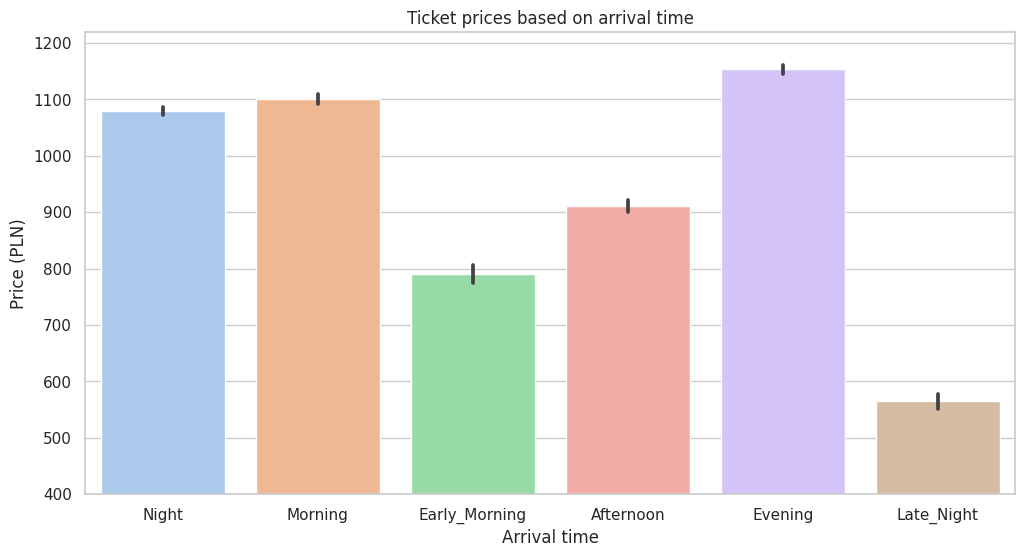

In [49]:
plt.figure(figsize=(12, 6))
sns.barplot(x='arrival_time', y='price_pln', data=df, palette="pastel")
plt.title('Ticket prices based on arrival time')
plt.xlabel('Arrival time')
plt.ylabel('Price (PLN)')
plt.ylim(400, None)
plt.show()


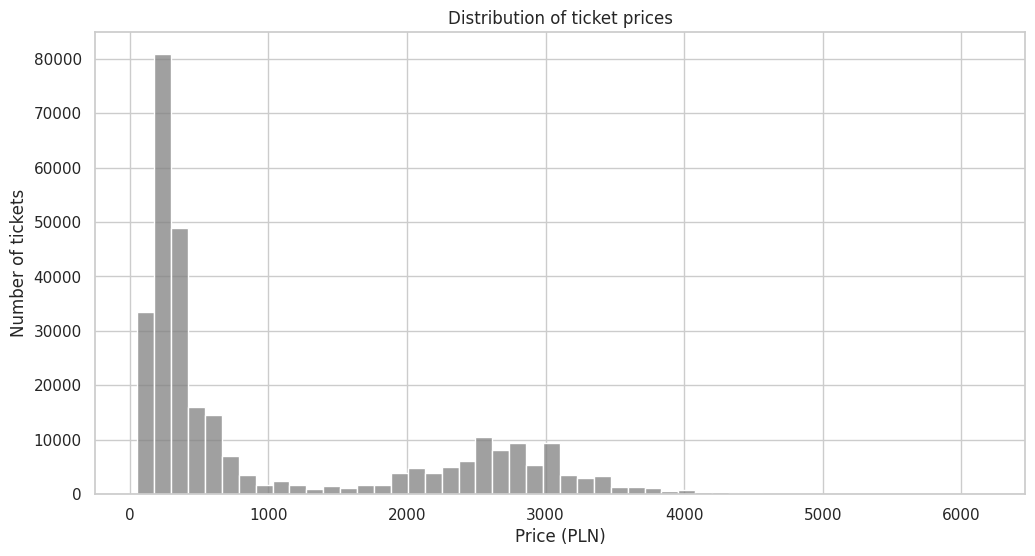

In [50]:
plt.figure(figsize=(12, 6))
sns.histplot(df['price_pln'], bins=50, color="gray")
plt.title('Distribution of ticket prices')
plt.xlabel('Price (PLN)')
plt.ylabel('Number of tickets')
plt.show()



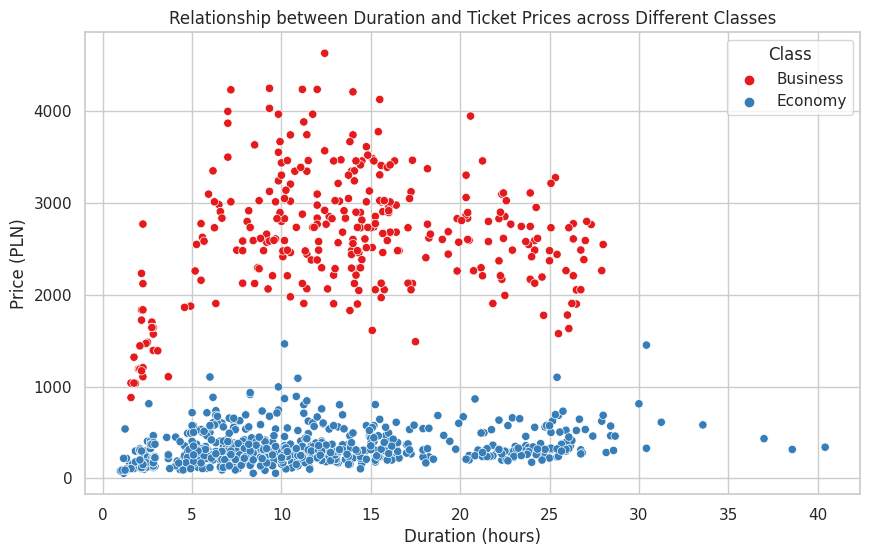

In [206]:
df_sample = df.sample(n=1000)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration', y='price_pln', hue='class', data=df_sample, palette='Set1')
plt.title('Relationship between Duration and Ticket Prices across Different Classes')
plt.xlabel('Duration (hours)')
plt.ylabel('Price (PLN)')
plt.legend(title='Class')
plt.show()


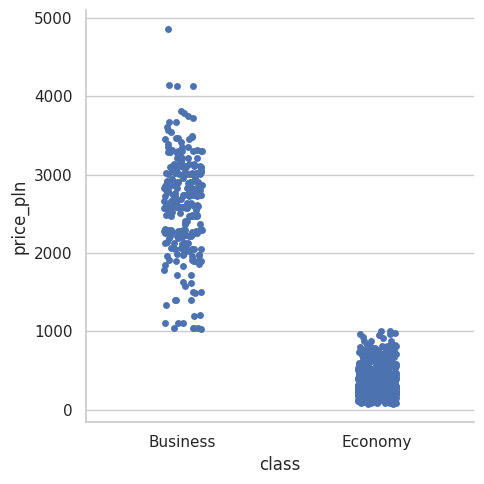

In [207]:
df_sample_2 = df.sample(n=1000)
sns.catplot(data=df_sample_2, x="class", y="price_pln", order=["Business", "Economy"])

In [ ]:
num_features = ['duration', 'days_left']
cat_features = ['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']


In [ ]:
num_pipe = Pipeline([
    ("scaler", StandardScaler())
    ])

In [ ]:
cat_pipe = Pipeline([
    ("encoder", OneHotEncoder(drop="if_binary", handle_unknown="ignore"))
    ])

In [ ]:
preprocessor = ColumnTransformer([
    ("num_branch", num_pipe, num_features),
    ("cat_branch", cat_pipe, cat_features)
], remainder="drop")

In [ ]:
X = df.drop(["price_pln"], axis=1)
y = df["price_pln"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor())
     ])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_branch',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'days_left']),
                                                 ('cat_branch',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore'))]),
                                                  ['airline', 'flight',
                                                   'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city',
                                                   'class'])])),
                ('model', RandomForestRegressor())])

In [ ]:
predicted_price = pipeline.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:

X_test_with_predictions = X_test.copy()
X_test_with_predictions['predicted_price_pln'] = predicted_price

In [ ]:
X_test_with_predictions.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,predicted_price_pln
192128,Air India,AI-9894,Chennai,Morning,one,Morning,Mumbai,Economy,25.67,35,305.291
197468,Indigo,6E-327,Chennai,Morning,zero,Afternoon,Bangalore,Economy,1.00,45,72.368
45815,Vistara,UK-810,Bangalore,Early_Morning,one,Afternoon,Mumbai,Business,8.00,45,3350.200
45130,Air India,AI-625,Mumbai,Morning,one,Night,Delhi,Economy,13.42,13,501.871
151966,Indigo,6E-7561,Kolkata,Early_Morning,two_plus,Evening,Chennai,Economy,9.67,42,203.079


In [ ]:
X_test_with_predictions.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_test_with_predictions['actual_price_pln'] = y_test


In [ ]:
X_test_with_predictions['actual_price_pln'] = y_test

In [ ]:
X_test_with_predictions.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,predicted_price_pln,actual_price_pln
0,Air India,AI-9894,Chennai,Morning,one,Morning,Mumbai,Economy,25.67,35,305.291,297.50
1,Indigo,6E-327,Chennai,Morning,zero,Afternoon,Bangalore,Economy,1.00,45,72.368,72.15
2,Vistara,UK-810,Bangalore,Early_Morning,one,Afternoon,Mumbai,Business,8.00,45,3350.200,3350.20
3,Air India,AI-625,Mumbai,Morning,one,Night,Delhi,Economy,13.42,13,501.871,491.40
4,Indigo,6E-7561,Kolkata,Early_Morning,two_plus,Evening,Chennai,Economy,9.67,42,203.079,208.50


In [ ]:
pd.set_option('display.max_rows', 20)
X_test_with_predictions.head(100)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,predicted_price_pln,actual_price_pln
0,Air India,AI-9894,Chennai,Morning,one,Morning,Mumbai,Economy,25.67,35,305.2910,297.50
1,Indigo,6E-327,Chennai,Morning,zero,Afternoon,Bangalore,Economy,1.00,45,72.3680,72.15
2,Vistara,UK-810,Bangalore,Early_Morning,one,Afternoon,Mumbai,Business,8.00,45,3350.2000,3350.20
3,Air India,AI-625,Mumbai,Morning,one,Night,Delhi,Economy,13.42,13,501.8710,491.40
4,Indigo,6E-7561,Kolkata,Early_Morning,two_plus,Evening,Chennai,Economy,9.67,42,203.0790,208.50
...,...,...,...,...,...,...,...,...,...,...,...,...
95,Vistara,UK-930,Mumbai,Early_Morning,one,Evening,Hyderabad,Business,12.42,42,3018.2500,3018.25
96,Indigo,6E-371,Hyderabad,Evening,zero,Evening,Bangalore,Economy,1.33,43,91.3655,88.80
97,Vistara,UK-613,Mumbai,Afternoon,two_plus,Evening,Hyderabad,Business,7.67,3,3428.6420,3417.55
98,Vistara,UK-828,Chennai,Early_Morning,two_plus,Early_Morning,Hyderabad,Economy,24.83,45,301.6000,301.60


In [ ]:

mse = mean_squared_error(y_test, X_test_with_predictions['predicted_price_pln'])
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 13959.323877855611


In [ ]:
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 118.14958263936276


In [ ]:
mae = mean_absolute_error(y_test, X_test_with_predictions['predicted_price_pln'])
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 43.075608675626235


In [ ]:
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Mean Squared Error: 13959.323877855611


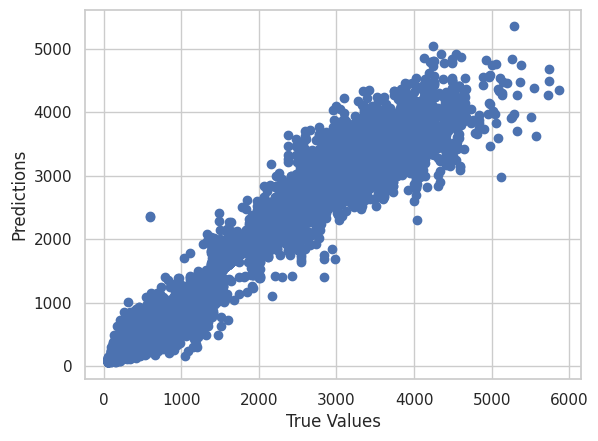

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

In [ ]:
# Załóżmy, że 'model' to twój wytrenowany model, a 'preprocessor' to twój ColumnTransformer dla przetwarzania danych

# 1. Przygotowanie nowych danych
new_data = pd.DataFrame({
    'airline': ['SpiceJet'],
    'flight': ['SG-8709'],
    'source_city': ['Delhi'],
    'departure_time': ['Evening'],
    'stops': ['zero'],
    'arrival_time': ['Night'],
    'destination_city': ['Mumbai'],
    'class': ['Economy'],
    'duration': [2.17],
    'days_left': [1]
})

# 2. Transformacja nowych danych
# Upewnij się, że preprocessor został wytrenowany na danych treningowych przed tym krokiem
new_data_transformed = preprocessor.transform(new_data)

# 3. Predykcja
# Upewnij się, że model został wytrenowany na przetworzonych danych treningowych przed tym krokiem
predicted_price = model.predict(new_data_transformed)

# 4. Interpretacja wyników
print(f"Predicted price: {predicted_price[0]}")



NotFittedError: ignored

In [ ]:
df.head()

In [ ]:
y_pred = model.predict(X_test_transformed)

NameError: ignored

In [ ]:
SpiceJet	SG-8709	Delhi	Evening	zero	Night	Mumbai	Economy	2.17	1	297.65

In [ ]:
score = model.score(X_test_transformed, y_test)
print("Accuracy: ", score)

NameError: ignored

In [ ]:
# Podział danych na zestaw treningowy i testowy
X = df.drop('price_pln', axis=1)
y = df['price_pln']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Wyodrębnienie cech numerycznych i kategorialnych
num_features = ['duration', 'days_left']
cat_features = ['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']

# Procesowanie cech numerycznych - normalizacja
num_transformer = StandardScaler()

# Procesowanie cech kategorialnych - one-hot encoding
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# Utworzenie końcowego przetwarzania danych przy użyciu ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

# Utworzenie pipeline'u
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', XGBRegressor())])

# Definicja siatki hiperparametrów do przeszukania
param_grid = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 4, 5]
}

# Utworzenie obiektu GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Dopasowanie modelu
grid_search.fit(X_train, y_train)

# Wyświetlenie najlepszych hiperparametrów
print("Najlepsze hiperparametry: ", grid_search.best_params_)

# Wyświetlenie najlepszego wyniku
print("Najlepszy wynik: ", grid_search.best_score_)

# Użycie najlepszego modelu do predykcji na zestawie testowym
y_pred = grid_search.predict(X_test)


Najlepsze hiperparametry:  {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 150}
Najlepszy wynik:  0.973483125932068


In [ ]:
# Lista modeli do przetestowania
models = [
    ("Random Forest", RandomForestRegressor()),
    ("Gradient Boosting", GradientBoostingRegressor()),
    ("XGBoost", XGBRegressor()),
    ("LightGBM", LGBMRegressor())
]

# Przetwarzanie wstępne danych
preprocessor = ColumnTransformer([
    ("num_branch", num_pipe, num_features),
    ("cat_branch", cat_pipe, cat_features)
], remainder="drop")

# Iteracja przez modele
for name, model in models:
    # Utworzenie pipeline dla danego modelu
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Trenowanie modelu
    pipeline.fit(X_train, y_train)

    # Ocenianie modelu (opcjonalnie)
    score = pipeline.score(X_test, y_test)
    print(f"Score for {name}: {score:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score for Random Forest: 0.9891


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score for Gradient Boosting: 0.9534


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score for XGBoost: 0.9769
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2631
[LightGBM] [Info] Number of data points in the train set: 240127, number of used features: 1165
[LightGBM] [Info] Start training from score 1044.776218


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Score for LightGBM: 0.9746
